# RLHF: 基于人类反馈的强化学习

In [1]:
import warnings
warnings.filterwarnings('ignore')

RLHF是一种将人类偏好融入模型训练过程的技术，通过人类反馈引导模型生成更符合人类期望的输出。

## 1.  RLHF的基本流程

1. **预训练语言模型**：使用自监督学习训练基础模型
2. **收集人类偏好数据**：人类评估者对模型生成的多个回答进行排序
3. **训练奖励模型**：基于人类偏好数据训练奖励模型
4. **使用强化学习优化策略**：通过PPO等算法优化模型策略

## 2. PPO（Proximal Policy Optimization）

- **原理**：通过限制策略更新步长来稳定训练过程
- **优势**：
  - 训练稳定性高
  - 样本效率好
  - 实现相对简单
- **挑战**：
  - 计算资源需求高
  - 实现复杂度较高
  - 超参数调整困难

##### 原理详解

PPO（近端策略优化）算法是一种强化学习算法，特别适用于连续动作空间和复杂环境。其核心思想是通过限制新旧策略之间的差异来稳定训练过程。

数学原理

1. **目标函数**：PPO的目标是最大化期望回报，同时限制策略更新的幅度：
   $$J^{PPO}(\theta) = \mathbb{E}_{t} \left[ \min(r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t) \right]$$
   
   其中：
   - $r_t(\theta) = \frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$ 是新旧策略的概率比
   - $\hat{A}_t$ 是优势函数估计
   - $\epsilon$ 是裁剪参数（通常为0.1或0.2）

2. **裁剪机制**：通过裁剪概率比来限制策略更新幅度，防止过大的更新导致训练不稳定

3. **优势估计**：使用广义优势估计（GAE）计算动作的优势值：
   $$\hat{A}_t = \delta_t + \gamma\lambda\delta_{t+1} + ... + (\gamma\lambda)^{T-t-1}\delta_{T-1}$$
   
   其中 $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$

算法流程

1. 使用当前策略 $\pi_{\theta_{old}}$ 收集一批轨迹数据
2. 估计每个时间步的优势值 $\hat{A}_t$
3. 通过多个小批次（mini-batch）优化目标函数 $J^{PPO}(\theta)$
4. 更新策略参数 $\theta$
5. 重复以上步骤直到收敛

在RLHF中的应用

在RLHF中，PPO用于优化语言模型以最大化人类偏好的奖励模型输出，同时保持与原始预训练模型的接近程度（通过KL散度惩罚项）。这种方法能有效平衡模型性能提升和避免过度优化导致的问题。



### 演示

Episode 10, Reward: 4.40, Loss: -0.4400
Episode 20, Reward: 4.40, Loss: -0.4400
Episode 30, Reward: 3.60, Loss: -0.3600
Episode 40, Reward: 2.80, Loss: -0.2800
Episode 50, Reward: 2.80, Loss: -0.2800


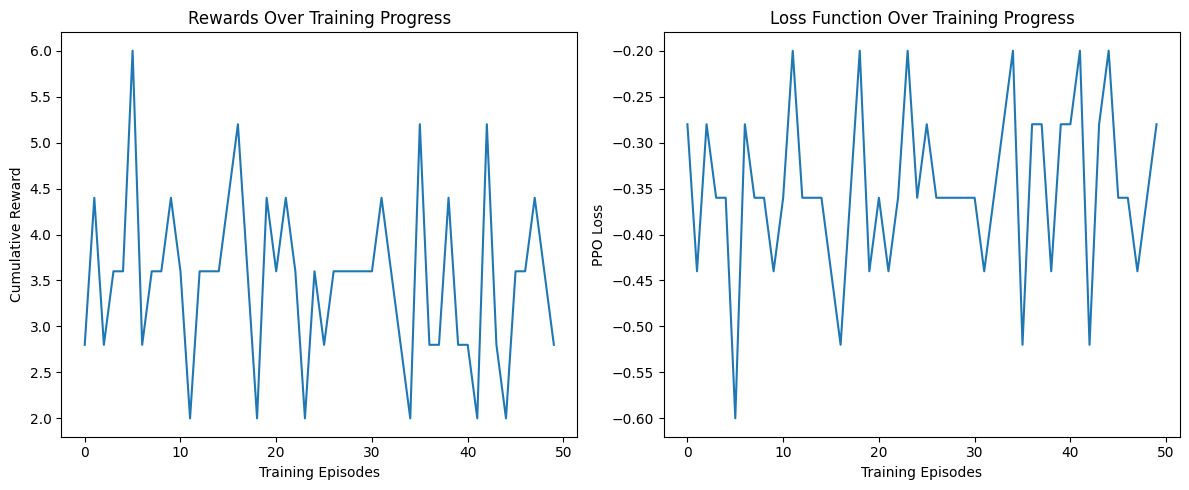

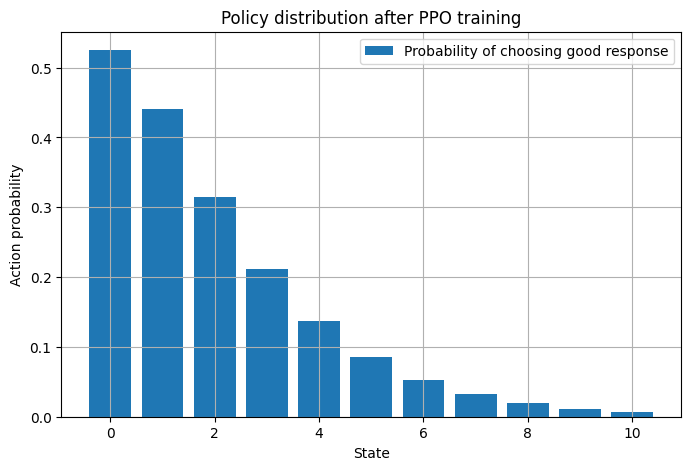

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

class SimpleEnv:
    def __init__(self):
        """
        初始化环境
        """
        self.state = 0       # 初始化环境状态为0
        self.done = False    # 初始化环境结束标志为False
        self.max_steps = 10  # 设置最大步数为10步
        self.current_step = 0 # 当前步数计数器初始化为0
        
    def reset(self):
        """
        重置环境到初始状态
        返回：初始状态值
        """
        self.state = 0       # 重置状态为0
        self.done = False    # 重置结束标志为False
        self.current_step = 0 # 重置步数计数器为0
        return self.state    # 返回初始状态
    
    def step(self, action):
        """
        执行一步动作并返回结果
        参数：
            action: 0或1的动作值，模拟模型生成的回答质量
        返回：
            state: 更新后的状态
            reward: 根据动作获得的奖励
            done: 环境是否结束的标志
        """
        # 动作0表示生成不太好的回答，动作1表示生成好的回答
        if action == 1:
            reward = 1.0  # 好的回答得到较高正向奖励
        else:
            reward = 0.2  # 不太好的回答得到较小奖励
            
        self.current_step += 1  # 步数计数器增加1
        if self.current_step >= self.max_steps:  # 检查是否达到最大步数
            self.done = True    # 如果达到最大步数，设置结束标志为True
            
        self.state += 1  # 状态值增加1，模拟环境状态变化
        return self.state, reward, self.done  # 返回新状态、奖励和结束标志

# 策略网络
class Policy(nn.Module):
    def __init__(self):
        """
        策略网络初始化函数
        构建一个简单的前馈神经网络作为策略模型
        """
        super(Policy, self).__init__()  # 调用父类初始化方法
        self.fc = nn.Sequential(
            nn.Linear(1, 16),    # 输入层：状态维度为1，隐藏层维度为16
            nn.ReLU(),           # 激活函数：ReLU
            nn.Linear(16, 2)     # 输出层：输出维度为2，对应两个可能的动作
        )
        
    def forward(self, x):
        """
        前向传播函数
        参数:
            x: 输入状态
        返回:
            logits: 未经过softmax的动作概率分布（对数概率）
        """
        x = torch.FloatTensor([x])  # 将输入转换为FloatTensor类型
        logits = self.fc(x)         # 通过神经网络计算logits值
        return logits               # 返回logits值
    
    def act(self, state):
        """
        根据当前状态选择动作
        参数:
            state: 当前环境状态
        返回:
            action: 选择的动作
            log_prob: 所选动作的对数概率，用于后续PPO算法计算
        """
        logits = self.forward(state)                # 获取logits值
        probs = torch.softmax(logits, dim=-1)       # 将logits转换为概率分布
        m = Categorical(probs)                      # 创建类别分布
        action = m.sample()                         # 从分布中采样一个动作
        return action.item(), m.log_prob(action)    # 返回动作值和对应的对数概率

# PPO算法实现
def ppo_update(policy, optimizer, states, actions, old_log_probs, rewards, epsilon=0.2):
    # 计算新策略的动作概率
    new_log_probs = []
    for state, action in zip(states, actions):
        logits = policy.forward(state)
        probs = torch.softmax(logits, dim=-1)
        m = Categorical(probs)
        new_log_probs.append(m.log_prob(torch.tensor(action)))
    
    new_log_probs = torch.stack(new_log_probs)
    old_log_probs = torch.stack(old_log_probs)
    
    # 计算比率
    ratio = torch.exp(new_log_probs - old_log_probs)
    
    # 计算裁剪后的目标函数
    rewards = torch.FloatTensor(rewards)
    surr1 = ratio * rewards
    surr2 = torch.clamp(ratio, 1.0 - epsilon, 1.0 + epsilon) * rewards
    loss = -torch.min(surr1, surr2).mean()
    
    # 更新策略
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

# 训练过程
def train_ppo():
    env = SimpleEnv()
    policy = Policy()
    optimizer = optim.Adam(policy.parameters(), lr=0.01)
    
    num_episodes = 50
    all_rewards = []
    all_losses = []
    
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        
        states = []
        actions = []
        log_probs = []
        rewards = []
        
        # 收集轨迹
        while not done:
            action, log_prob = policy.act(state)
            next_state, reward, done = env.step(action)
            
            states.append(state)
            actions.append(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            
            state = next_state
        
        # 更新策略
        loss = ppo_update(policy, optimizer, states, actions, log_probs, rewards)
        
        # 记录结果
        episode_reward = sum(rewards)
        all_rewards.append(episode_reward)
        all_losses.append(loss)
        
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode+1}, Reward: {episode_reward:.2f}, Loss: {loss:.4f}")
    
    return policy, all_rewards, all_losses

# 运行训练
policy, rewards, losses = train_ppo()

# 可视化结果
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('Rewards Over Training Progress')
plt.xlabel('Training Episodes')
plt.ylabel('Cumulative Reward')

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title('Loss Function Over Training Progress')
plt.xlabel('Training Episodes')
plt.ylabel('PPO Loss')

plt.tight_layout()
plt.show()

# 展示训练前后策略的变化
def visualize_policy(policy):
    """
    展示训练前后策略的变化
    参数:
        policy: 训练后的策略网络
    """
    states = np.linspace(0, 10, 11)
    action_probs = []
    
    for state in states:
        logits = policy.forward(state)
        probs = torch.softmax(logits, dim=-1).detach().numpy()
        action_probs.append(probs[-1])  # 只获取选择好回答的概率
    
    plt.figure(figsize=(8, 5))
    plt.bar(states, action_probs, label='Probability of choosing good response')
    plt.xlabel('State')
    plt.ylabel('Action probability')
    plt.title('Policy distribution after PPO training')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_policy(policy)


## 3. DPO（Direct Preference Optimization）

- **原理**：直接从偏好数据中学习，无需显式的奖励模型
- **优势**：
  - 简化了RLHF流程
  - 减少了计算资源需求
  - 训练更加稳定
- **实现方式**：
  ```python
  # DPO训练示例代码
  from trl import DPOTrainer
  
  # 初始化DPO训练器
  dpo_trainer = DPOTrainer(
      model,
      ref_model,
      tokenizer=tokenizer,
      train_dataset=train_dataset,
      beta=0.1,           # DPO损失中的温度参数
      max_length=512,     # 最大序列长度
      max_prompt_length=128  # 最大提示长度
  )
  
  # 开始训练
  dpo_trainer.train()
  ```